# Промежуточный проект

### Автор: Кузнецов С.И.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
from sklearn import tree
import seaborn as sns
%matplotlib inline

### Исходный датасет

**Item_Identifier** - Id продукта

**Item_Weight** - Вес продукта

**Item_Fat_Content** - Содержание жира в продукте

**Item_Visibility** - %полок, отведенный под наш продукт в конкретном магазине

**Item_Type** - Категория продукта

**Item_MRP** - Максимальная цена продажи продукта

**Outlet_Identifier** - Идентификатор магазина

**Outlet_Establishment_Year** - Год открытия магазина

**Outlet_Size** - Площадь магазина

**Outlet_Location_Type** - Тип города, в котором расположен магазин

**Outlet_Type** - Признак является ли магазин продуктовым или супермаркетом

**Item_Outlet_Sales** - Продажи продукта в конкретном магазине. Именно ее и надо предсказывать

In [2]:
data = pd.read_csv('data.csv')
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
data.shape

(8523, 12)

До начала анализа разобъем выборку на обучающую и тестовую. Анализ датасета и построение моделей будем проводить только на обучающей выборке. Тестовая выборка будет использоваться для валидации построенных моделей.

Будем считать обучающей выборкой данные по магазинам, открытым в 2002 году или ранее. Данные по магазинам, открытым с 2004 года включительно, будем счтиать тестовой выборкой.

Разбиваем выборку на обучающую и тестовую случайным образом в соотношении 70 на 30.

In [4]:
test_index = set(random.choices(data.index.values, k = round(data.shape[0] * 0.3)))
train_index = set(data.index.values) - test_index 
data_train = data.iloc[list(train_index)]
data_test = data.iloc[list(test_index)]

In [5]:
data_train.shape

(6299, 12)

In [6]:
data_test.shape

(2224, 12)

#### 1. Провести EDA

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6299 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              6299 non-null object
Item_Weight                  5193 non-null float64
Item_Fat_Content             6299 non-null object
Item_Visibility              6299 non-null float64
Item_Type                    6299 non-null object
Item_MRP                     6299 non-null float64
Outlet_Identifier            6299 non-null object
Outlet_Establishment_Year    6299 non-null int64
Outlet_Size                  4549 non-null object
Outlet_Location_Type         6299 non-null object
Outlet_Type                  6299 non-null object
Item_Outlet_Sales            6299 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 639.7+ KB


In [8]:
data_train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,5193.000000,6299.000000,6299.000000,6299.000000,6299.000000
mean,12.851575,0.065979,140.858447,1997.764883,2189.278296
std,4.664425,0.051370,62.253320,8.406121,1728.740524
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027056,93.779100,1987.000000,834.247400
50%,12.600000,0.053611,142.283800,1999.000000,1794.331000
75%,16.850000,0.094337,185.756900,2004.000000,3098.633200
max,21.350000,0.325781,266.888400,2009.000000,13086.964800


Датасет содержит 3 числовые фичи.

In [9]:
number_feature_names = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']  # Имена числовых переменных
target_feature = 'Item_Outlet_Sales'  # Целевая переменная

Построим графики попарного распределения фичей

/home/sergmath/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sergmath/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


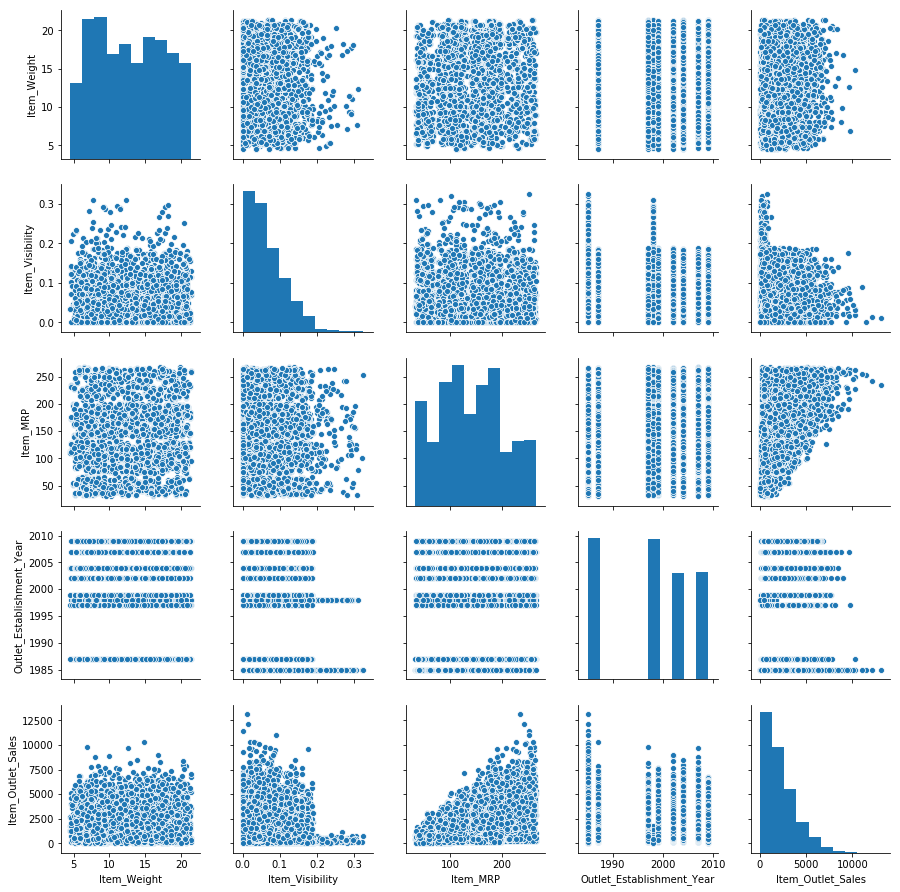

In [10]:
_ = sns.pairplot(
    data_train[number_feature_names + [target_feature]]
)

Видно, что фича *Item_Visibility* может быть разделена на 3 диапазона, на каждом из которых средние значения продаж разные. Найдем границы этих диапазонов. Для этого построим дерево решений с максимальным количеством "листов", равным 3. 

In [11]:
dtr = DecisionTreeRegressor(max_leaf_nodes=3)
dtr.fit(data_train[['Item_Visibility']], data_train.Item_Outlet_Sales)
print(tree.export_text(dtr))

|--- feature_0 <= 0.19
|   |--- feature_0 <= 0.10
|   |   |--- value: [2311.30]
|   |--- feature_0 >  0.10
|   |   |--- value: [1914.03]
|--- feature_0 >  0.19
|   |--- value: [383.16]



Видно, что границы диапазонов: $(-\infty; 0,10)$, $[0,10; 0,19)$ и $[0,19; \infty)$

Создадим соответствующие категориальные фичи:

In [12]:
def get_interval(x, points):
    if x < points[0]:
        return('#-inf#{}'.format(points[0]))
    
    for i in range(1, len(points)):
        if x < points[i]:
            return('#{}#{}'.format(points[i - 1], points[i]))
    
    return('#{}#inf'.format(points[-1]))

def add_interval_feature(df, feature_name, points):
    res = df.join(
        pd.get_dummies(
            df[feature_name].apply(
                get_interval,
                points = points
            ),
            prefix = feature_name,
        prefix_sep = ''
        ),
    )
    
    return res

In [13]:
data_train = add_interval_feature(data_train, 'Item_Visibility', [0.1, 0.19])
data_test = add_interval_feature(data_test, 'Item_Visibility', [0.1, 0.19])

Проверим гипотезы, что в каждом из интервалов мат. ожидания целевой переменной отличаются.

In [14]:
stats.ttest_ind(data_train.Item_Outlet_Sales[data_train['Item_Visibility#-inf#0.1'] == 1],
               data_train.Item_Outlet_Sales[data_train['Item_Visibility#0.1#0.19'] == 1])

Ttest_indResult(statistic=7.277999249175484, pvalue=3.8087204855941805e-13)

In [15]:
stats.ttest_ind(data_train.Item_Outlet_Sales[data_train['Item_Visibility#-inf#0.1'] == 1],
               data_train.Item_Outlet_Sales[data_train['Item_Visibility#0.19#inf'] == 1])

Ttest_indResult(statistic=12.094801756387378, pvalue=3.2575400397848815e-33)

In [16]:
stats.ttest_ind(data_train.Item_Outlet_Sales[data_train['Item_Visibility#0.1#0.19'] == 1],
               data_train.Item_Outlet_Sales[data_train['Item_Visibility#0.19#inf'] == 1])

Ttest_indResult(statistic=10.78104598382678, pvalue=4.298623875586517e-26)

Принимаем гипотезы, что в каждом из интервалов мат. ожидания целевой переменной отличаются.

Аналогичным образом разбиваем фичу *Outlet_Establishment_Year* на интервалы

In [17]:
dtr = DecisionTreeRegressor(max_leaf_nodes=2)
dtr.fit(data_train[['Outlet_Establishment_Year']], data_train.Item_Outlet_Sales)
print(tree.export_text(dtr))

|--- feature_0 <= 1997.50
|   |--- value: [2386.20]
|--- feature_0 >  1997.50
|   |--- value: [2062.59]



Проверяем гипотезу, что средний уровень продаж в магазинах, открытых до 1998 года отличается от среднего уровня продаж в магазинах, открытых с 1998 года, включительно.

In [18]:
stats.ttest_ind(data_train.Item_Outlet_Sales[data_train['Outlet_Establishment_Year'] < 1998],
               data_train.Item_Outlet_Sales[data_train['Outlet_Establishment_Year'] >= 1998])

Ttest_indResult(statistic=7.281182232529247, pvalue=3.7128149693084556e-13)

Гипотеза принимается. Создаем соответствующие интервальные фичи.

In [19]:
data_train = add_interval_feature(data_train, 'Outlet_Establishment_Year', [1998])
data_test = add_interval_feature(data_test, 'Outlet_Establishment_Year', [1998])

Построим матрицу корреляций

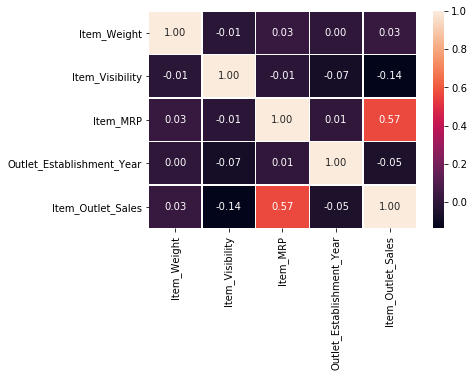

In [20]:
corr_number_features = data_train[number_feature_names + [target_feature]].corr()
_ = sns.heatmap(corr_number_features,
                annot=True, 
                xticklabels=corr_number_features.columns.values, 
                yticklabels=corr_number_features.index.values,
                fmt=".2f", 
                linewidths=0.5
               )

**Выводы:**
1. Из всех числовых фичей самая большая корреляция с целевой переменной у фичи *Item_MRP*.
2. Фича *Item_Visibility* имеет 3 диапазона, в каждом из которых среднее значение целевой переменной меняется скачком.
3. Средний уровень продаж в магазинах, открытых до 1998 года отличается от среднего уровня продаж в магазинах, открытых с 1998 года, включительно.

#### 2. Обработать категориальные признаки

**Item_Identifier** - Id продукта.

In [21]:
data_train.Item_Identifier.value_counts()

NCF42    9
FDG09    9
FDZ21    8
FDV38    8
FDF56    8
NCL31    8
FDA15    8
FDP25    8
NCE31    8
NCQ06    8
DRK12    8
FDF16    8
FDW49    8
FDW26    8
FDD38    8
DRE49    8
FDA50    8
FDC41    7
FDC14    7
FDZ20    7
FDY35    7
NCY18    7
FDR01    7
FDT21    7
FDQ56    7
FDK08    7
NCL53    7
FDX50    7
FDY47    7
FDO57    7
        ..
FDF38    1
FDU47    1
DRF51    1
FDV58    1
FDA48    1
NCM42    1
FDA37    1
FDT33    1
FDV27    1
FDP07    1
NCW30    1
FDA57    1
FDT38    1
FDU03    1
FDP37    1
FDC23    1
FDO33    1
FDJ02    1
FDS10    1
NCM55    1
FDU43    1
DRG25    1
FDY25    1
FDP15    1
FDE52    1
FDV31    1
FDZ34    1
NCU06    1
FDM38    1
FDB47    1
Name: Item_Identifier, Length: 1548, dtype: int64

Каждый идентификатор состоит из 2х частей: 3 символов и 2-значного числа. Выделим первые 3 символа как отдельный признак.

Использование идентификатора в качестве признака невозможно, так как слишком мало данных о продажах по каждому конкретному Id товара.

In [22]:
data_train['Item_Identifier_Prefix'] = data_train.Item_Identifier.apply(lambda x: x[:3])
data_test['Item_Identifier_Prefix'] = data_test.Item_Identifier.apply(lambda x: x[:3])
data_train['Item_Identifier_Prefix'].value_counts()

FDX    224
FDS    213
FDR    210
FDW    207
FDY    203
FDZ    202
FDT    202
FDV    193
FDU    191
FDB    186
FDO    173
FDA    172
FDD    171
FDH    170
FDQ    170
FDP    170
FDC    166
FDL    158
FDG    154
FDN    146
FDK    146
FDI    145
FDF    145
FDE    142
FDJ    141
FDM    123
NCN     71
NCO     70
NCL     63
NCP     58
      ... 
DRD     46
NCE     44
NCB     44
NCS     44
NCR     43
NCZ     42
NCY     41
NCU     41
NCX     41
DRJ     40
NCD     39
NCF     39
NCC     37
NCH     36
DRM     36
NCG     35
NCV     35
NCA     35
NCW     35
NCT     35
DRL     34
DRC     28
DRN     25
DRA     18
DRB     18
DRO     12
DRP     10
DRZ      8
DRY      6
DRQ      6
Name: Item_Identifier_Prefix, Length: 71, dtype: int64

Создадим числовую фичу, равную медианному значению целевой переменной для каждого префикса на обучающей выборке. 

In [23]:
sales_by_ID = data_train.groupby('Item_Identifier_Prefix').Item_Outlet_Sales.median().to_dict()
data_train['Item_Identifier_Mean_Sales'] = data_train.Item_Identifier_Prefix.apply(lambda x: sales_by_ID.get(x))
data_test['Item_Identifier_Mean_Sales'] = data_test.Item_Identifier_Prefix.apply(lambda x: sales_by_ID.get(x))

**Item_Fat_Content** - Содержание жира в продукте

In [24]:
data_train.Item_Fat_Content.value_counts()

Low Fat    3731
Regular    2164
LF          236
low fat      85
reg          83
Name: Item_Fat_Content, dtype: int64

Переменная принимает одно из 2х значений: "Низкое содержание" и "Норма"
Создадим числовую фичу, которая принимает значение 1, если содержание жира в продукте низкое, и 0, если оно нормальное.

In [25]:
data_train['Item_Fat_Content_Low_Fat'] = \
data_train.Item_Fat_Content.apply(lambda x: 1 if x in {'Low Fat', 'low fat', 'LF'} else 0)

data_test['Item_Fat_Content_Low_Fat'] = \
data_test.Item_Fat_Content.apply(lambda x: 1 if x in {'Low Fat', 'low fat', 'LF'} else 0)

**Item_Type** - Категория продукта

In [26]:
data_train.Item_Type.value_counts()

Fruits and Vegetables    915
Snack Foods              879
Household                674
Frozen Foods             629
Baking Goods             497
Dairy                    493
Canned                   486
Health and Hygiene       388
Soft Drinks              334
Meat                     308
Breads                   183
Hard Drinks              155
Others                   126
Starchy Foods            108
Breakfast                 84
Seafood                   40
Name: Item_Type, dtype: int64

Введем числовую фичу, равную медианному значению уровня продаж каждого типа продуктов на обучающей выборке.

In [27]:
sales_by_type = data_train.groupby('Item_Type').Item_Outlet_Sales.median().to_dict()
data_train['Item_Type_Mean_Sales'] = data_train.Item_Type.apply(lambda x: sales_by_type.get(x))
data_test['Item_Type_Mean_Sales'] = data_test.Item_Type.apply(lambda x: sales_by_type.get(x))

In [28]:
data_train.Outlet_Identifier.value_counts()

OUT049    707
OUT027    696
OUT018    691
OUT013    690
OUT035    685
OUT017    675
OUT046    670
OUT045    666
OUT019    410
OUT010    409
Name: Outlet_Identifier, dtype: int64

**Outlet_Size** - Площадь магазина;

**Outlet_Location_Type** - Тип города, в котором расположен магазин;

**Outlet_Type** - Признак является ли магазин продуктовым или супермаркетом

Сделаем соответвующие числовые фичи с помощью *getdummies*

In [29]:
data_train.Outlet_Size.value_counts()

Medium    2094
Small     1765
High       690
Name: Outlet_Size, dtype: int64

In [30]:
data_train.Outlet_Location_Type.value_counts()

Tier 3    2486
Tier 2    2026
Tier 1    1787
Name: Outlet_Location_Type, dtype: int64

In [31]:
data_train.Outlet_Type.value_counts()

Supermarket Type1    4093
Grocery Store         819
Supermarket Type3     696
Supermarket Type2     691
Name: Outlet_Type, dtype: int64

In [32]:
data_train = pd.get_dummies(data_train, columns = ['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'])
data_test = pd.get_dummies(data_test, columns = ['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'])

#### 3. Устранить пропущенные значения.

В датасете пропущенные значения имеют только 2 переменные: *Item_Weigth* и *Outlet_Size*.

Для заполнения пустых значений переменной *Item_Weigth* будем брать среднее значение веса продукта с тем же ID. Если ни у одного товара с тем же ID не будет указан вес - в качестве веса примем медианное значение по категории товара.

In [33]:
Weight_by_ID = data_train.groupby('Item_Identifier').median().Item_Weight.to_dict()
Weight_by_type = data_train.groupby('Item_Type').median().Item_Weight.to_dict()

In [34]:
data_train['Item_Weight_all_1'] = data_train.apply(lambda x: Weight_by_ID.get(x.Item_Identifier) \
                                                   if np.isnan(x.Item_Weight) else x.Item_Weight, axis = 1)

data_train['Item_Weight_all'] = data_train.apply(lambda x: Weight_by_type.get(x.Item_Type) \
                                                 if np.isnan(x.Item_Weight_all_1) else x.Item_Weight_all_1, axis = 1)

data_train.drop(columns = 'Item_Weight_all_1', inplace = True)

data_test['Item_Weight_all_1'] = data_test.apply(lambda x: Weight_by_ID.get(x.Item_Identifier) \
                                                   if np.isnan(x.Item_Weight) else x.Item_Weight, axis = 1)

data_test['Item_Weight_all'] = data_test.apply(lambda x: Weight_by_type.get(x.Item_Type) \
                                                 if np.isnan(x.Item_Weight_all_1) else x.Item_Weight_all_1, axis = 1)

data_test.drop(columns = 'Item_Weight_all_1', inplace = True)

Пустые значения категориальной переменной *Outlet_Size* выделим в отдельную категорию.

#### 4. Изучить корреляцию признаков с данными о продажах

Для построения модели будем использовать следующие фичи:

In [35]:
model_feature_names = [
    'Item_MRP',
    'Item_Visibility#-inf#0.1',
    'Item_Visibility#0.1#0.19',
    'Item_Visibility#0.19#inf',
    'Outlet_Establishment_Year#-inf#1998',
    'Outlet_Establishment_Year#1998#inf',
    'Item_Identifier_Mean_Sales',
    'Item_Fat_Content_Low_Fat',
    'Item_Type_Mean_Sales',
    'Outlet_Size_High',
    'Outlet_Size_Medium',
    'Outlet_Size_Small',
    'Outlet_Location_Type_Tier 1',
    'Outlet_Location_Type_Tier 2',
    'Outlet_Location_Type_Tier 3',
    'Outlet_Type_Grocery Store',
    'Outlet_Type_Supermarket Type1',
    'Outlet_Type_Supermarket Type2',
    'Outlet_Type_Supermarket Type3',
    'Item_Weight_all'
]

Таблица корреляций между фичами:

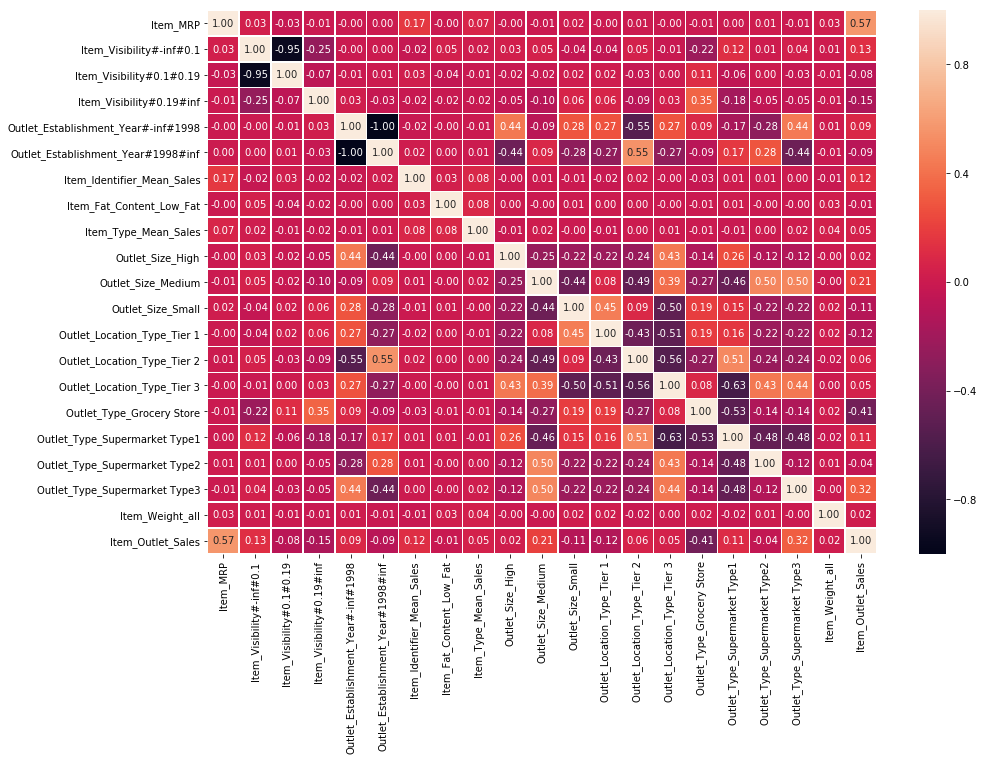

In [36]:
plt.figure(figsize = (15, 10))
corr_model_features = data_train[model_feature_names + [target_feature]].corr()
_ = sns.heatmap(corr_model_features, 
                annot=True, 
                xticklabels=corr_model_features.columns.values, 
                yticklabels=corr_model_features.index.values,
                fmt=".2f", 
                linewidths=0.5
               )

Больше всего с данными о продажах коррелируют фичи:
* Item_MRP
* Outlet_Type_Grocery Store
* Outlet_Type_Supermarket Type3

#### 5. Выбрать и обосновать метрику, на основе которой будем измерять качество полученной модели.

В качестве метрики примем метрику $r^2$. Причины:
1. Наша задача - определить признаки, которые больше всего влияют на объем продаж. Метрика $r^2$ показывает долю дисперсии, которую объясняет рассматриваемая модель. Используя эту метрику можно выявить, какие фичи доют наибольший вклад в дисперсию объемов продаж.Соответственно, это и будут самые значимые параметры.
2. Метрика $r^2$ изменяется в диапазоне от 0 до 1. Следовательно, мы будем знать, насколько мы близки к идеальной модели, в отличие от метрик MSE/RMSE

#### 6. Построить и подобрать оптимальные параметры для любой линейной модели

Доопределим фичи, которые попали в обучающую выборку, но не попали в тестовую.

Фичи, которые не попали в тестовую выборку:

In [37]:
features_in_train_only = set(model_feature_names) - set(data_test.columns.values)
features_in_train_only

set()

In [38]:
for f in features_in_train_only:
    data_test[f] = 0

In [39]:
data_test[model_feature_names].head()

,Item_MRP,Item_Visibility#-inf#0.1,Item_Visibility#0.1#0.19,Item_Visibility#0.19#inf,Outlet_Establishment_Year#-inf#1998,Outlet_Establishment_Year#1998#inf,Item_Identifier_Mean_Sales,Item_Fat_Content_Low_Fat,Item_Type_Mean_Sales,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight_all
2,141.6180,1,0,0,0,1,2018.0398,1,1903.8551,0,1,0,1,0,0,0,1,0,0,17.50
3,182.0950,1,0,0,0,1,2077.6289,0,1771.0280,0,0,0,0,0,1,1,0,0,0,19.20
8196,198.5426,1,0,0,0,1,1713.7692,0,1858.9136,0,0,0,0,1,0,0,1,0,0,13.00
4,53.8614,1,0,0,1,0,838.9080,1,2065.3116,1,0,0,0,0,1,0,1,0,0,8.93
8197,58.8588,1,0,0,0,1,1653.8472,0,1930.8200,0,0,1,0,1,0,0,1,0,0,13.65


In [40]:
X_train = data_train[model_feature_names]
X_test = data_test[model_feature_names]
y_train = data_train[target_feature]
y_test = data_test[target_feature]

В качестве линейной модели выберем линейную регрессию с регуляризацией методом Лассо.

In [41]:
mdl_ls = Lasso()
params_lasso = {
    'alpha': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
    'normalize': [True, False],
    'tol': [0.00005, 0.0001, 0.00015, 0.0002, 0.00025, 0.0003, 0.00035, 0.0004, 0.00045, 0.0005]
}
mdl_lasso = GridSearchCV(mdl_ls, params_lasso, scoring = 'r2', n_jobs = -1, cv = 5)

In [42]:
%%time
mdl_lasso.fit(X_train, y_train)

CPU times: user 7.49 s, sys: 378 ms, total: 7.86 s
Wall time: 1min 7s


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3,
                                   1.4, 1.5],
                         'normalize': [True, False],
                         'tol': [5e-05, 0.0001, 0.00015, 0.0002, 0.00025,
                                 0.0003, 0.00035, 0.0004, 0.00045, 0.0005]},
             scoring='r2')

Лучшие параметры

In [43]:
mdl_lasso.best_params_

{'alpha': 0.8, 'normalize': False, 'tol': 0.0005}

Оценим качество модели с подобранными параметрами на тестовой выборке.

In [44]:
mdl_ls = Lasso(alpha = 0.8, normalize = False, tol = 0.0005)
mdl_ls.fit(X_train, y_train)
r2_score(y_test, mdl_ls.predict(X_test))

0.5429572255791061

Построим модель - дерево решений.

In [45]:
mdl_dt = DecisionTreeRegressor()
params_dt = {
    'max_depth': [4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_impurity_decrease':[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
}
mdl_dec_tree = GridSearchCV(mdl_dt, params_dt, scoring = 'r2', n_jobs = -1, cv = 5)

In [46]:
%%time
mdl_dec_tree.fit(X_train, y_train)

CPU times: user 20 s, sys: 675 ms, total: 20.7 s
Wall time: 2min 4s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'min_impurity_decrease': [0, 0.01, 0.02, 0.03, 0.04,
                                                   0.05, 0.06, 0.07, 0.08, 0.09,
                                                   0.1],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='r2')

In [47]:
mdl_dec_tree.best_params_

{'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 2}

Оценим качество модели на тестовой выборке

In [48]:
mdl_dt = DecisionTreeRegressor(max_depth = 5, min_impurity_decrease = 0, min_samples_split = 2)
mdl_dt.fit(X_train, y_train)
r2_score(y_test, mdl_dt.predict(X_test))

0.5675360922478564

Составим таблицу значимости фичей

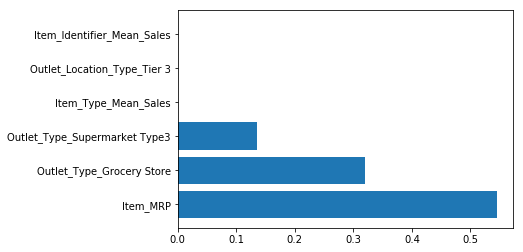

In [49]:
FI_table = pd.DataFrame(
    {
        'feature': X_train.columns,
        'feature_importance': mdl_dt.feature_importances_
    }
)

FI_table = FI_table[FI_table.feature_importance >= 0.000001].sort_values(by = 'feature_importance',
                                                                         ascending = False)

_ = plt.barh(FI_table.feature, FI_table.feature_importance)

Построим теперь линейную регрессию. В модель войдут только фичи с уровнем значимости более 0.000001.
Оптимальное количество фичей определим, последовательно обучая модель на разном количестве фичей и измеряя точность с помощью кросс-валидации.

In [50]:
num_of_features = np.arange(FI_table.shape[0])

avg_score = []

for n in num_of_features:
    lr = LinearRegression()
    avg_score.append(cross_val_score(estimator = lr,
                                     X = X_train[FI_table.feature[:(n + 1)]],
                                     y = y_train,
                                     scoring = 'r2',
                                     n_jobs = -1,
                                     cv = 5).mean()
                    )
    print(FI_table.feature.iloc[n])
lr_scores = pd.DataFrame({'num_of_features' : num_of_features, 'avg_score': avg_score})
lr_scores.num_of_features += 1
lr_scores

Item_MRP
Outlet_Type_Grocery Store
Outlet_Type_Supermarket Type3
Item_Type_Mean_Sales
Outlet_Location_Type_Tier 3
Item_Identifier_Mean_Sales


,num_of_features,avg_score
0,1,0.320674
1,2,0.488323
2,3,0.562614
3,4,0.562272
4,5,0.563587
5,6,0.563527


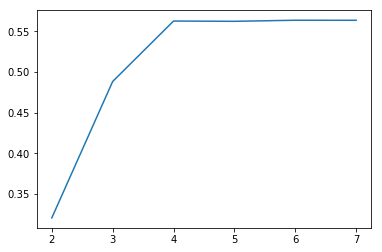

In [51]:
plt.plot(lr_scores.num_of_features + 1, lr_scores.avg_score)

**Вывод:** Оптимально строить модель на 3х фичах

In [52]:
lr = LinearRegression()
lr.fit(X_train[FI_table.feature[:3]], y_train)
r2_score(y_test, lr.predict(X_test[FI_table.feature[:3]]))

0.5416302392317297

Коэффициенты модели:

In [53]:
lr.intercept_

54.58379741577164

In [54]:
for f, c in zip(FI_table.feature[:3], lr.coef_):
    print(f, ':', c)

Item_MRP : 15.728588077469317
Outlet_Type_Grocery Store : -1910.7311773038693
Outlet_Type_Supermarket Type3 : 1517.0498286502202


#### 7. Построить и подобрать оптимальные параметры для любой нелинейной модели

Построим и обучим модель методом градиентного бустинга.

In [55]:
mdl_gb = GradientBoostingRegressor()
params_gb = {
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5, 6],
    'n_estimators':[30, 40, 50, 60]
}
mdl_grad_boosting = GridSearchCV(mdl_gb, params_gb, scoring = 'r2', n_jobs = -1, cv = 5)

In [56]:
%%time
mdl_grad_boosting.fit(X_train, y_train)

CPU times: user 5.92 s, sys: 221 ms, total: 6.14 s
Wall time: 2min 15s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 6],
                         'n_estimators': [30, 40, 50, 60]},
             scoring='r2')

In [57]:
mdl_grad_boosting.best_params_

{'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}

In [59]:
mdl_gb = GradientBoostingRegressor(max_depth = 3, 
                                   min_samples_split = 2, 
                                   n_estimators = 50)

mdl_gb.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=50)

In [60]:
r2_score(y_test, mdl_gb.predict(X_test))

0.5755669905071825

#### 8. Провести стекинг нескольких моделей

In [61]:
feature_names = X_train.columns.values
feature_names

array(['Item_MRP', 'Item_Visibility#-inf#0.1', 'Item_Visibility#0.1#0.19',
       'Item_Visibility#0.19#inf', 'Outlet_Establishment_Year#-inf#1998',
       'Outlet_Establishment_Year#1998#inf', 'Item_Identifier_Mean_Sales',
       'Item_Fat_Content_Low_Fat', 'Item_Type_Mean_Sales',
       'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3', 'Item_Weight_all'], dtype=object)

In [62]:
X_train['fold'] = np.random.choice(np.arange(10).tolist(), size = X_train.shape[0], replace=True)

/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
stack = dict()  # Стэк моделей
model_names = set() # Имена моделей
# Объединяем 3 модели: Дерево решений, Лассо и Градиентный бустинг
for f in X_train.fold.unique():
    stack[f] = {
        'dt_model': DecisionTreeRegressor(max_depth = 5, min_impurity_decrease = 0, min_samples_split = 2),
        'linear_model': LinearRegression(),
        'gb_model': GradientBoostingRegressor(max_depth = 3, min_samples_split = 2, n_estimators = 50)
    }
    
    for model_name, mdl in stack[f].items():
        if model_name == 'linear_model':
            mdl.fit(X_train[X_train.fold == f][FI_table.feature[:3]], y_train[X_train.fold == f])
        else:
            mdl.fit(X_train[X_train.fold == f][feature_names], y_train[X_train.fold == f])
        model_names.add(model_name)
        
    print('Fold', f, 'done')
model_names

Fold 9 done
Fold 7 done
Fold 5 done
Fold 3 done
Fold 6 done
Fold 0 done
Fold 1 done
Fold 8 done
Fold 2 done
Fold 4 done


{'dt_model', 'gb_model', 'linear_model'}

In [65]:
# Выполним предсказания по каждой из моделей на обучающей выборке 
# (не предсказываем результат на том фолде, на котором выборка обучалась)
for model_name in model_names:
    print(model_name)
    X_train[model_name] = np.nan
    X_test[model_name] = np.nan
    
    # Обучающая выборка
    for f in X_train.fold.unique():
        predict_data = []
        print(f)
        
        for fld in stack.keys():
            if fld != f:
                if model_name == 'linear_model':
                    predict_data.append(stack[fld][model_name].predict(X_train[X_train.fold == f][FI_table.feature[:3]]))
                else:
                    predict_data.append(stack[fld][model_name].predict(X_train[X_train.fold == f][feature_names]))

        X_train[model_name][X_train.fold == f] = np.array(predict_data).mean(axis = 0)
    
    # Тестовая выборка
    
    print('Test')
    predict_data = []
    for fld in stack.keys():
        if model_name == 'linear_model':
            predict_data.append(stack[fld][model_name].predict(X_test[FI_table.feature[:3]]))
        else:
            predict_data.append(stack[fld][model_name].predict(X_test[feature_names]))
            
        X_test[model_name] = np.array(predict_data).mean(axis = 0)

linear_model


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


9


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


7


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


5


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


3


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


6


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


0


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


1


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


8


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


2


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


4


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


Test


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

gb_model


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


9


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


7


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


5


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


3


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


6


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


0


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


1


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


8


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


2


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


4


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/sergmath/anaco

Test


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

dt_model
9


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


5


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


3


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


6


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


0


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


1


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


8


/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaco

2


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


4


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/sergmath/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/sergmath/anaco

Test


/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

Обучаем итоговую модель на основе стекинга 3х моделей.

In [66]:
model_names = list(model_names)
common_model = LinearRegression()
common_model.fit(X_train[model_names], y_train)

LinearRegression()

#### 9. Оценить качество моделей на отложенной выборке

Оценим качество стекинга 3х моделей на тестовой выборке по метрике $r^2$ 

In [67]:
r2_score(y_test, common_model.predict(X_test[model_names]))

0.5797995173304382

#### 10.  Выбрать топ 3 признака больше всего влияющие на объемы продаж

In [68]:
FI_table

,feature,feature_importance
0,Item_MRP,0.544701
15,Outlet_Type_Grocery Store,0.320118
18,Outlet_Type_Supermarket Type3,0.135039
8,Item_Type_Mean_Sales,0.000076
14,Outlet_Location_Type_Tier 3,0.000035
6,Item_Identifier_Mean_Sales,0.000031


**Top-3 признака, влияющик на объемы продаж:**
* Item_MPR - Максимальная цена продажи продукта
* Outlet_Type - Тип торговой точки
* Item_Identifier_Mean_Sales - средний уровень продаж товара с соответствующим идентификатором
